In [16]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

from mpl_toolkits.mplot3d import Axes3D
import random
import time

from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

import warnings
warnings.filterwarnings('ignore')

In [17]:
#counterFactualListCollection is a dict of the generations of counterfactualLists for an individual
def displayCounterFactuals(counterFactualListCollection, generation):
    dataFrame = counterFactualListCollection[generation]
    ages = []
    priors_counts = []
    juv_fel_counts = []
    person_encoding = []
    for row in dataFrame.index:
        # store x, y, z for the 3D scatterplot
        ages.append(dataFrame.at[row, 'age'])
        priors_counts.append(dataFrame.at[row, 'priors_count'])
        juv_fel_counts.append(dataFrame.at[row, 'juv_fel_count'])
        
        # sex_Male|sex_Female|race_African_American|race_Caucasian|race_Hispanic|race_Other|c_charge_degree_F 
        binary_encoding = [dataFrame.at[row, 'sex_Male'],
                           dataFrame.at[row, 'sex_Female'],
                           dataFrame.at[row, 'race_African_American'],
                           dataFrame.at[row, 'race_Caucasian'],
                           dataFrame.at[row, 'race_Hispanic'],
                           dataFrame.at[row, 'race_Other'],
                           dataFrame.at[row, 'c_charge_degree_F']]
        
        # use unique encoding of a person as index for color on 3D display
        person_encoding.append(int("".join(str(x) for x in binary_encoding), 2))
       
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # plot the values
    ax.scatter(ages, priors_counts, person_encoding, zdir='z', s=20, c=person_encoding, depthshade=True)
    ax.set_xlabel('age')
    ax.set_ylabel('priors_count')
    ax.set_zlabel('juv_fel_count')
    
    plt.pause(0.05)
    
    

In [18]:
def displayDriver(counterFactualListCollection):
    print(len(counterFactualListCollection))
    i = 0
    while i < len(counterFactualListCollection):
        displayCounterFactuals(counterFactualListCollection, i)
        plt.show()
        i = i+1

In [19]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )

print(full_data.shape)


# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text', 'id']
full_data = full_data.loc[:, columns_kept]

full_data.set_index('id')

full_data.head()



(7214, 53)
(6130, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text,id
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,African-American,1,0,Low,1
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,African-American,1,0,Low,3
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,African-American,1,0,Low,4
5,Male,44,25 - 45,Other,0,0,M,0,1,0,2013-11-30 04:50:18,2013-12-01 12:28:56,Caucasian,0,1,Low,7
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,African-American,1,0,Medium,8


In [20]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,sex_Male,race_African_American,race_Caucasian,race_Hispanic,race_Other,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,...,1,0,0,0,1,1,0,Low,1,0
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,1,1,0,0,0,1,0,Low,1,0
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,1,0,0,0,1,0,Low,1,0
5,Male,44,25 - 45,Other,0,0,M,0,1,0,...,1,0,0,0,1,0,1,Low,1,0
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,0,1,0,0,1,0,MediumHigh,0,1


In [21]:
X_Labels = ['sex_Male', 'sex_Female', 'age', 'race_African_American', 'race_Caucasian', 'priors_count',\
            'race_Hispanic', 'race_Other', 'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)




[0]	test-auc:0.81849
[1000]	test-auc:0.84334
[2000]	test-auc:0.84634
[3000]	test-auc:0.84599
[4000]	test-auc:0.84558
[5000]	test-auc:0.84475
[6000]	test-auc:0.84375
[7000]	test-auc:0.84289
[8000]	test-auc:0.84229
[9000]	test-auc:0.84161
[9999]	test-auc:0.84089


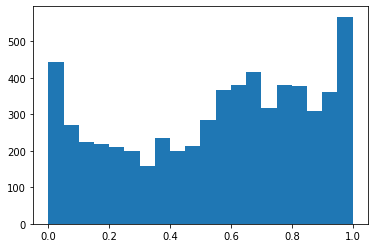

In [22]:
%matplotlib inline
plt.hist(learning_data['pred'], bins = 20)
plt.show()


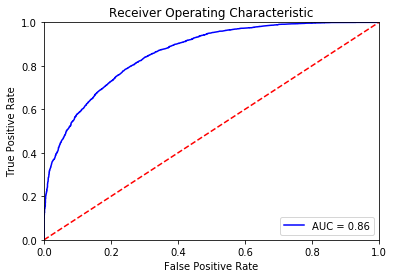

Optimal Threshold obtained using difference of TPR and FPR 0.5727081


In [23]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [24]:

class CounterFactFactory:
    # do we need to mutate catagorical and continous data seperately? 
    # we probably need to ask for some bounds on each feature

    # bounds is a dict with form {<feature_name>: (<"catagorical"/"continous">, <number catagories/continous scale>)}
    # continous scale is max value for generating the initial population continous features
    # -(continous scale) is min value for generating the initial population
    def __init__(self, indiv, model_pred_func, bounds, fit_func, 
               selection_rate=.5, prob_mut=.2, prob_cross=.5, init_pop_size=1000,
               round_func=np.around, generations=200,
               **kwargs):
        self.model_pred_func = model_pred_func  # f(x)
        self.indiv = indiv                      # x
        self.c_fact_list = pd.DataFrame()       # subset of I
        self.feature_bounds = bounds            # may be used for mutation
        self.fitness = fit_func                 # d(x, c)
        self.pop_size = init_pop_size
        self.round_func = round_func
        self.p_s = selection_rate
        self.p_m = prob_mut
        self.p_c = prob_cross
        self.indiv_class = self.round_func(self.model_pred_func(xgboost.DMatrix(self.indiv)))
        self.indiv_class = self.indiv_class[0]
        self.gen = generations
        
        self.catL = [] 
        self.conL = []
        self.feature_names =  []
        
        self.c_fact_list_collection = {}
        
        
        for feature_name in self.feature_bounds:
            bounds = self.feature_bounds[feature_name]
            self.feature_names.append(feature_name)
            if bounds[0].startswith("cat"):
                self.catL.append(feature_name)
            elif bounds[0].startswith("cont"):
                self.conL.append(feature_name)
            else:
                print("error in bounds dictionary")
                print("expected catagorical or continous and got neither")
                raise ValueError()



    # step 7
    def genRandomCFactuals(self):
        
        temp = None
        if not self.c_fact_list.empty:
            temp = self.c_fact_list.columns
            
        # keep generating counter factuals until our population is up to size
        while self.c_fact_list.shape[0] < self.pop_size:
            # generate new individuals
            new_indivs = pd.DataFrame()
            for feature_name in self.feature_names:
                bounds = self.feature_bounds[feature_name]
                if bounds[0].startswith("cat"):
                    # catagorical random
                    new_indivs[feature_name] = np.random.randint(0, bounds[1], size=self.pop_size-self.c_fact_list.shape[0])
                elif bounds[0].startswith("cont"):
                    # continous random
                    new_indivs[feature_name] = np.random.rand(self.pop_size-self.c_fact_list.shape[0], 1) * (bounds[1])
                else:
                    print("error in bounds dictionary")
                    print("expected catagorical or continous and got neither")
            # calculate new predictions and filter
            new_indivs['prediction'] = new_indivs.apply(lambda row : 
                                                      self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                      axis = 1)
            new_indivs = new_indivs[new_indivs.prediction != self.indiv_class]

            # add the survivors to the dataframe
            if temp is None:
                temp = new_indivs.columns
                
            self.c_fact_list = pd.concat([self.c_fact_list, new_indivs], axis=0)
            self.c_fact_list = self.c_fact_list[temp]
            
    # step 8
    def selection(self):
        if self.c_fact_list is pd.DataFrame.empty:
            print("attempted to select on an empty population")
            print("try calling genRandomCFactuals first?")
            print("if this appears from a call of getCFactuals then its a bug. please report it")
            return

        # sort by fitness and then keep the top half
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis=1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index
                                                 ])[:int(self.c_fact_list.shape[0]*self.p_s)]

    # step 9
    def mutation(self):
        # get individuals to mutate
        to_mut_indivs = self.c_fact_list.sample(frac=self.p_m, axis=0)

        # mutate the individuals
        for index, individual in to_mut_indivs.iterrows():
          # do the mutation in place
          individual[0] = 0

        # set the counter factuals to their mutated version
        self.c_fact_list.loc[to_mut_indivs.index] = to_mut_indivs

        # recalculate the predictions
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                                self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                axis = 1)
        
        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)

    # step 10
    def crossover(self):
        # make sure to recalculate the fitnesses, and predictions
        # make sure to filter out
        # idea: 
        #1. sort by fitness, and keep top p_c portion. 
        #2. cross over between c_0 & c_1, c_2 & c_3, and so on
        #3. to cross over, swap each feature value with 50% probability
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index])
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        
        count = self.c_fact_list.shape[0] * self.p_c
        i = 0
        while i < count:
            for feature_name in self.feature_bounds:
                if(np.random.random_sample() > 0.5):
                    old_val = self.c_fact_list.loc[i, feature_name]
                    self.c_fact_list.loc[i, feature_name] = self.c_fact_list.loc[i+1, feature_name]
                    self.c_fact_list.loc[i, feature_name] = old_val
            i = i + 2
        pass
    
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                        self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                        axis = 1)

        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)
        

    # step 11
    def filterCFacts(self):
        # filter the population of counter factuals (self.c_fact_list) to remove all
        # individuals that have the same prediction class (self.indiv_class) as the original 
        # individual (self.indiv)
        self.c_fact_list = self.c_fact_list[self.c_fact_list.prediction != self.indiv_class]
        pass

    # step 12
    def getCFactuals(self):

        for generation in range(self.gen):
            self.genRandomCFactuals()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.selection()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.mutation()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.crossover()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.filterCFacts()
            self.c_fact_list.reset_index(drop=True, inplace=True)
           
            self.c_fact_list_collection[generation] = self.c_fact_list
            
            if(generation == self.gen-1):
                print("Generation", generation, "with max fitness", self.c_fact_list.fitness.max())
            
        return self.c_fact_list.loc[0, :]


In [25]:
def d(indiv, other, cat, con):
    
    agg = pd.DataFrame(indiv)
    agg.loc[1] = other
    agg.reset_index(drop=True, inplace=True)
    
    ncat = len(cat)
    ncon = len(con)
    
    xcat = agg.loc[:, cat]
    xcon = agg.loc[:, con]
        
    # MAD normalized L1 Norm
    normedl1norm = 0
    for feature in con:
        mad = burden_data.loc[:, feature].mad()
        normedl1norm += abs(xcon.loc[0, feature] - xcon.loc[1, feature]) / mad
    
    # simpMat
    # both pos
    xcat = xcat.astype('int32')
    PosMat = xcat.loc[0] & xcat.loc[1] 
    NegMat = (1 - xcat.loc[0]) & (1 - xcat.loc[1])
    total = xcat.shape[1]
    dist = (PosMat.sum() + NegMat.sum())/total
    
    n = ncat + ncon
    return ncon*normedl1norm/n + ncat*dist/n

working on indiv 0
Generation 24 with max fitness 0.41894006236214165
final set of lists
25


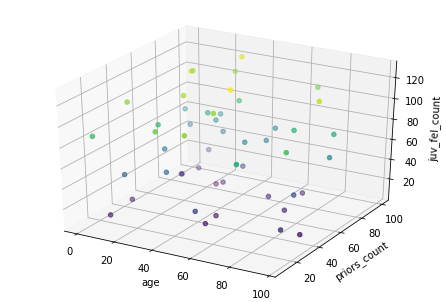

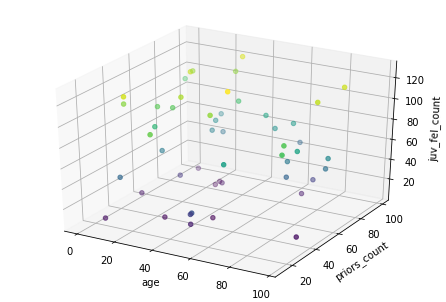

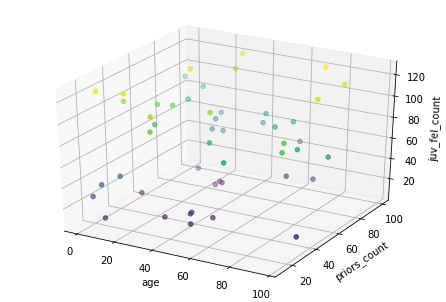

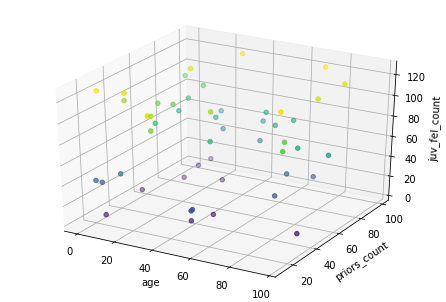

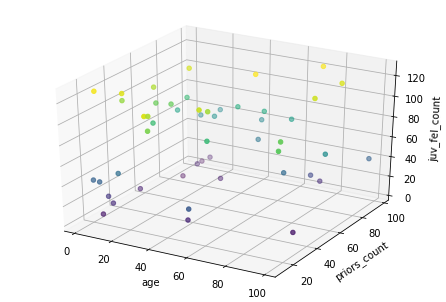

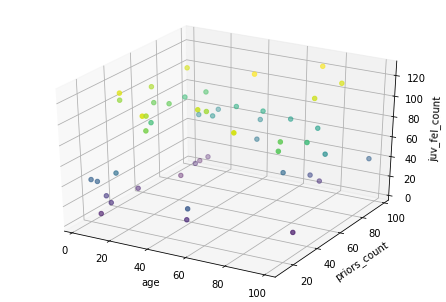

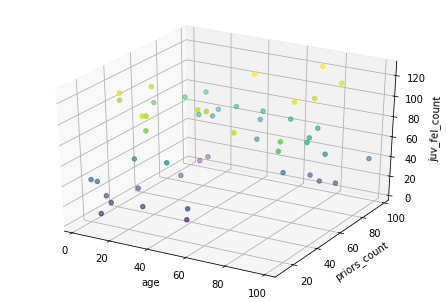

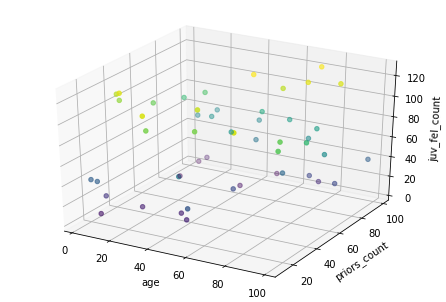

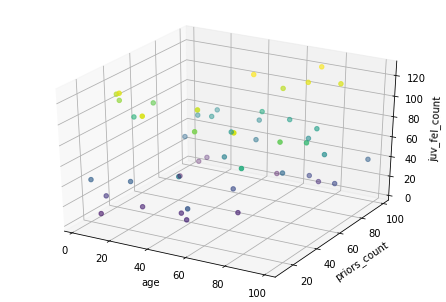

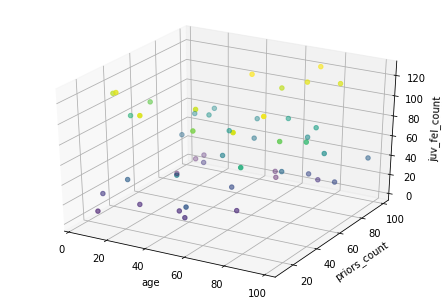

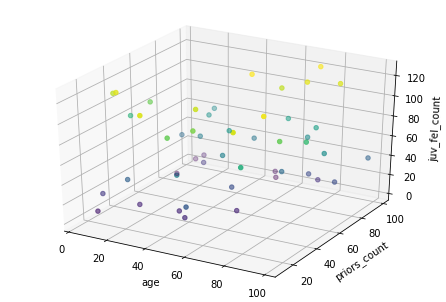

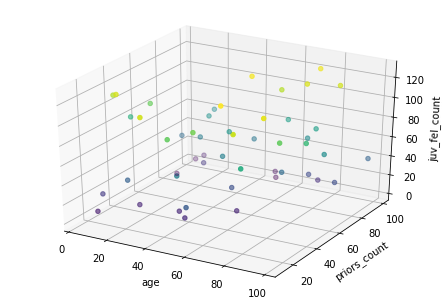

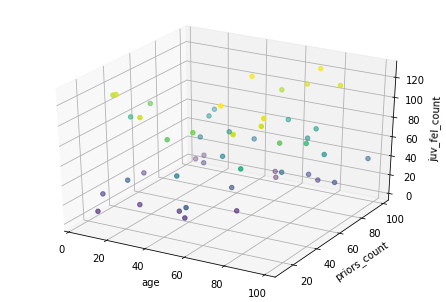

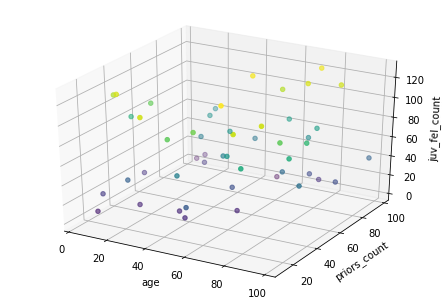

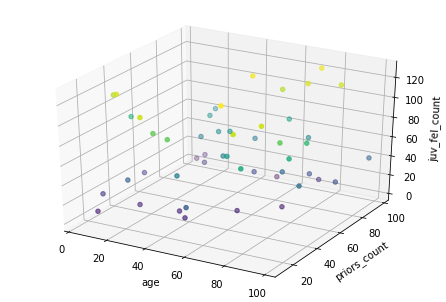

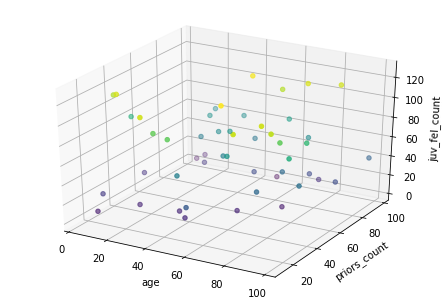

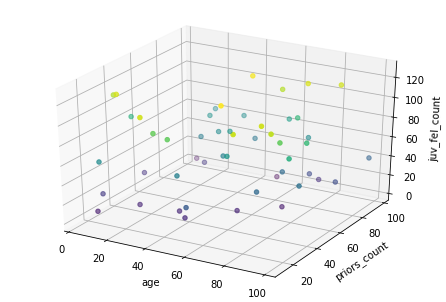

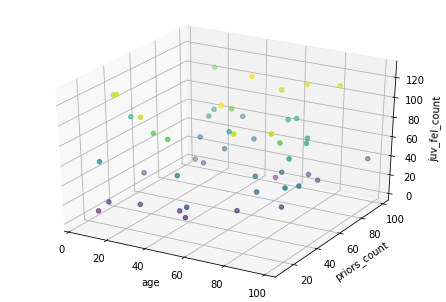

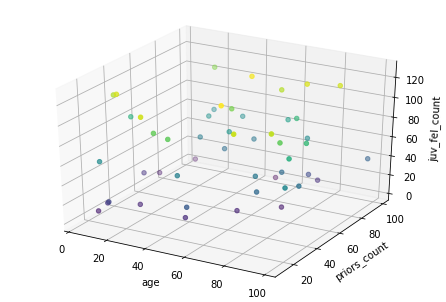

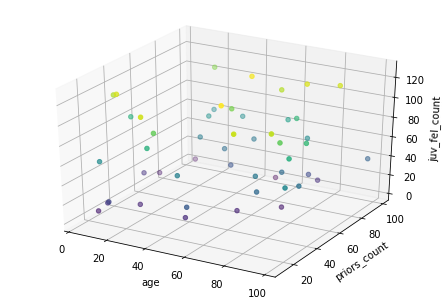

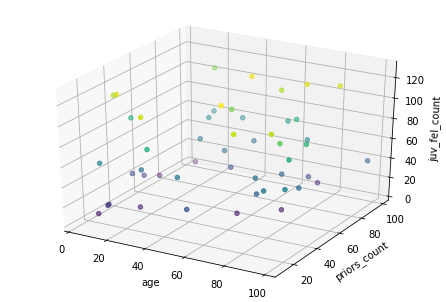

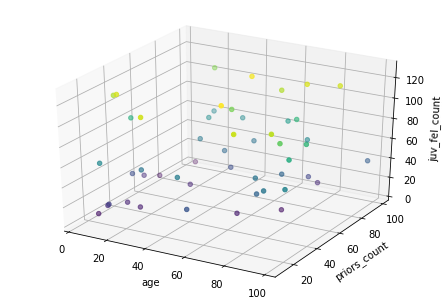

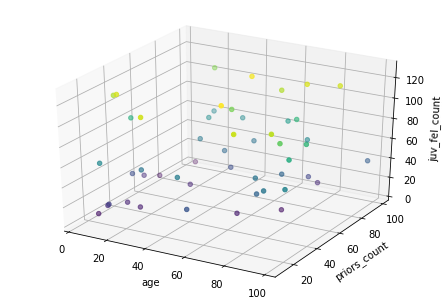

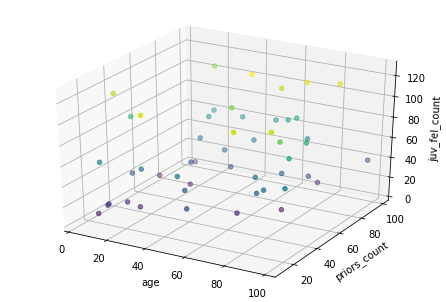

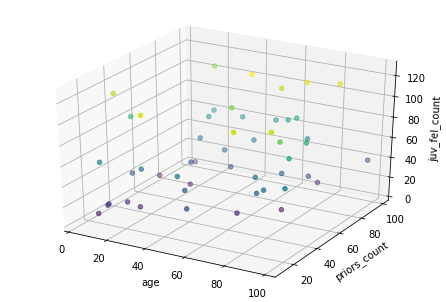

working on indiv 1


KeyboardInterrupt: 

In [26]:

b = {
    'sex_Male':   ("catagorical", 2),
    'sex_Female': ("catagorical", 2),
    'age':        ("continous", 100),
    'race_African_American': ("catagorical", 2),
    'race_Caucasian': ("catagorical", 2),
    'priors_count':   ("continous", 100),
    'race_Hispanic':  ("catagorical", 2),
    'race_Other':     ("catagorical", 2),
    'juv_fel_count':  ("continous", 100),
    'c_charge_degree_F': ("catagorical", 2),
    'c_charge_degree_M': ("catagorical", 2)
}

cdf = pd.DataFrame(columns=['fitness']+X_Labels)
burden_data = learning_data.loc[:, X_Labels]

def inv_dist(ind, otr, cat, con):
    return 1 / d(ind, otr, cat, con)

for i in range(int(learning_data.shape[0])):
    
    burden_indiv = pd.DataFrame(burden_data.iloc[i]).T
    
    c_fact = CounterFactFactory(indiv=burden_indiv, model_pred_func=model.predict, bounds=b, 
                            fit_func=inv_dist, init_pop_size=100, generations=25)

    print("working on indiv", str(i))
    final_c_fact = c_fact.getCFactuals()
    cdf = cdf.append(final_c_fact)
    
    print("final set of lists")
    #displayCounterFactuals(c_fact.c_fact_list_collection, 0)
    displayDriver(c_fact.c_fact_list_collection)
    #print(c_fact.c_fact_list_list)
    
cdf.index = burden_data.index
cdf.head()

In [27]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['Low'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "pburden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "other":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_n2p = sn2p[0]
            disa_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_n2p = on2p[0]
            disa_n2p = sn2p[0]
                
        priv_neg = priv_df[priv_df['y_pred'] == 0]
        disa_neg = disa_df[disa_df['y_pred'] == 0]
                
        num_priv_n2p = int(priv_n2p * priv_df.shape[0]) 
        priv_ind = np.asarray(priv_neg.sort_values('cfact_dist', ascending = True).id)[:num_priv_n2p]     
        num_disa_n2p = int(disa_n2p * disa_df.shape[0]) 
        disa_ind = np.asarray(disa_neg.sort_values('cfact_dist', ascending = True).id)[:num_disa_n2p]


        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]
        
        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "other":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                            
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "burden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]
        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [28]:
cdf = pd.read_pickle("./compas_cfact_10_22_2020_15_00.pkle")    

In [29]:
burden_d_df = learning_data.copy()

burden_d_df.reset_index(drop=True, inplace=True)
cdf.index = burden_d_df.index
burden_d_df['id'] = burden_d_df.index
cdf['id'] = cdf.index

aa_df = burden_d_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_d_df['race_African_American']  == 1]
c_df = burden_d_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_d_df['race_African_American']  == 0]

aa_m = Model(aa_df, cdf.loc[aa_df.index])
c_m = Model(c_df, cdf.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print()
print(Model(pd.concat([aa_m.datadf, c_m.datadf]), cdf))
print(Model(pd.concat([bf_aa_m.datadf, bf_c_m.datadf]), cdf))

[1.] [0.23787988] [0.73184237] [2.2108237e-10] burden
[1.] [0.23787988] [0.73184237] [2.2108237e-10]
African American
before 
 Accuracy:	0.751
F.P. cost:	0.286
F.N. cost:	0.388
Base rate:	0.424
Avg. score:	0.424
burden 
 Accuracy:	0.618
F.P. cost:	0.479
F.N. cost:	0.351
Base rate:	0.424
Avg. score:	0.551
random 
 Accuracy:	0.751
F.P. cost:	0.336
F.N. cost:	0.323
Base rate:	0.491
Avg. score:	0.503

Caucasian
before 
 Accuracy:	0.803
F.P. cost:	0.453
F.N. cost:	0.201
Base rate:	0.693
Avg. score:	0.693
burden 
 Accuracy:	0.636
F.P. cost:	0.375
F.N. cost:	0.416
Base rate:	0.693
Avg. score:	0.520
random 
 Accuracy:	0.803
F.P. cost:	0.317
F.N. cost:	0.249
Base rate:	0.572
Avg. score:	0.565

Accuracy:	0.776
F.P. cost:	0.342
F.N. cost:	0.275
Base rate:	0.554
Avg. score:	0.554
Accuracy:	0.627
F.P. cost:	0.444
F.N. cost:	0.390
Base rate:	0.554
Avg. score:	0.536


In [30]:
agg_fair = pd.concat([aa_m.datadf, c_m.datadf])
agg_fair['two_year_recid'] = learning_data['two_year_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['two_year_recid'] = learning_data['two_year_recid']



print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['two_year_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(agg_fair[agg_fair['pred'] >= .5][agg_fair['two_year_recid'] == 0].shape[0]/agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['two_year_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.3792822185970636
burden based derived predictor's accuracy relative to ground truth
0.2823817292006525
random derived predictor's accuracy relative to ground truth
0.2707993474714519


In [ ]:
cdf.to_pickle("./compas_cfact.pkle")    

### Demographic parity

In [31]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

print(rf_c_dp)
print(rf_aa_dp)
print()

print(bf_c_dp)
print(bf_aa_dp)
print()

print(c_dp)
print(aa_dp)
print()

0.5641286
0.59307086

0.50287646
0.6862992

0.7708968
0.46614173

